## Step 1: Install necessary packages

In [1]:
# Install necessary packages
!pip install mne
!pip install gluonts
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.0 MB/s eta 0:00:00


In [2]:
ls

sample_data/


In [3]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 86 (delta 23), reused 11 (delta 11), pack-reused 55
Receiving objects: 100% (86/86), 176.84 KiB | 8.84 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [4]:
cd lag-llama

/content/lag-llama


In [5]:
!pip install -r requirements.txt # this could take some time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.1
    Uninstalling pydanti

### download the pretrained model weights

In [6]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmpzmcgsyct
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 212MB/s]
/content/lag-llama/lag-llama.ckpt


### Import

In [7]:
import mne
import pandas as pd
import numpy as np
import torch
from itertools import islice
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset
from lag_llama.gluon.estimator import LagLlamaEstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Step 2: Prepare the EEG data

In [8]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)
print(raw)
print(raw.info)

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.37TB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 01m50s (1576.2 MB)
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.3 MB, data not loaded>
<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 

### Get the data for the time series


In [116]:
data, times = raw.get_data(return_times=True)
print(type(data))

<class 'numpy.ndarray'>


### Normalization

Z-Score Normalization: Z-Score normalization standardizes the data by subtracting the mean and dividing by the standard deviation. This ensures that the data has a mean of 0 and a standard deviation of 1.

In [110]:
def z_score_normalization(data):

  mean = data.mean(axis=1, keepdims=True)
  std = data.std(axis=1, keepdims=True)

  # Apply Z-Score normalization to EEG data
  normalized_data = (data - mean) / std

  return normalized_data



# # Verify the shape and type of normalized data
# print("Normalized Data Shape:", normalized_data.shape)
# print("Normalized Data Type:", type(normalized_data))

Min-max normalization: Min-Max scaling transforms the data to a specific range, typically between 0 and 1, by subtracting the minimum value and dividing by the range of values.

In [118]:
from sklearn.preprocessing import MinMaxScaler

def min_max_normalization(data):
  # Reshape EEG data if needed (e.g., for MinMaxScaler)
  data_reshaped = data.reshape(-1, 1)

  # Initialize MinMaxScaler
  scaler = MinMaxScaler()

  # Fit and transform EEG data using MinMaxScaler
  scaled_data = scaler.fit_transform(data_reshaped)

  # Reshape the scaled data back to its original shape
  scaled_data = scaled_data.reshape(data.shape)

  return scaled_data

### Create dataset

In [35]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

def create_dataset(data):

  time_index = pd.date_range(start='2023-01-01 00:00:00', periods=41700, freq='0.00665984S')
  df = pd.DataFrame(data.T, index=time_index, columns=["target"])

  # Set numerical columns as float32
  for col in df.columns:
      # Check if column is not of string type
      if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
          df[col] = df[col].astype('float32')

  dataset = PandasDataset(df, target="target")
  return dataset

## Step 3: Lag-Llama model

### Get predictions

In [37]:
def get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0')) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]


    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with


        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)


    return forecasts, tss

### Set the parameters for forecasting

In [111]:
PREDICTION_LENGTH = 100  # Define your prediction length
NUM_SAMPLES = 50 # number of samples sampled from the probability distribution for each timestep
NUM_CHANNELS = 10 # number of channles that we want to forecast

### Forecast and plot first 12 (NUM_CHANNELS) EEG channels
Green color -> forecasts \
Blue color -> target

In [114]:
def plot(forecasts_arr, tss_arr):
  plt.figure(figsize=(20, 50))
  plt.rcParams.update({'font.size': 15})

  # Iterate through the first  series, and plot the predicted samples
  for idx, (forecast, ts) in islice(enumerate(zip(forecasts_arr, tss_arr)), NUM_CHANNELS):
    forecast = forecast[0]
    ts = ts[0]
    ax = plt.subplot(5, 2, idx+1)

    plt.plot(ts[-3* PREDICTION_LENGTH:].to_timestamp(), label="target", )
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    ax.set_title(f'channel {idx + 1}')
    plt.xlabel('Time (seconds:milliseconds)')

  plt.gcf().tight_layout()
  plt.legend()
  plt.show()

### Forecasting without data normalization

In [120]:
forecasts_arr, tss_arr = [], []

for i in range(NUM_CHANNELS):
  # create dataset for a channel
  dataset = create_dataset(data[i])
  # get forecasts and tss for a channel
  forecasts, tss = get_lag_llama_predictions(dataset, PREDICTION_LENGTH, NUM_SAMPLES)
  forecasts_arr.append(forecasts)
  tss_arr.append(tss)

plot(forecasts_arr, tss_arr)

### Forecasting with z-score data normalization

In [ ]:
forecasts_arr, tss_arr = [], []
z_score_normalized_data = z_score_normalization(data)

for i in range(NUM_CHANNELS):
  # create dataset for a channel
  dataset = create_dataset(z_score_normalized_data[i])
  # get forecasts and tss for a channel
  forecasts, tss = get_lag_llama_predictions(dataset, PREDICTION_LENGTH, NUM_SAMPLES)
  forecasts_arr.append(forecasts)
  tss_arr.append(tss)

plot(forecasts_arr, tss_arr)

<ipython-input-110-127500d2026c>:7: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - mean) / std


### Forecasting with min max data normalization

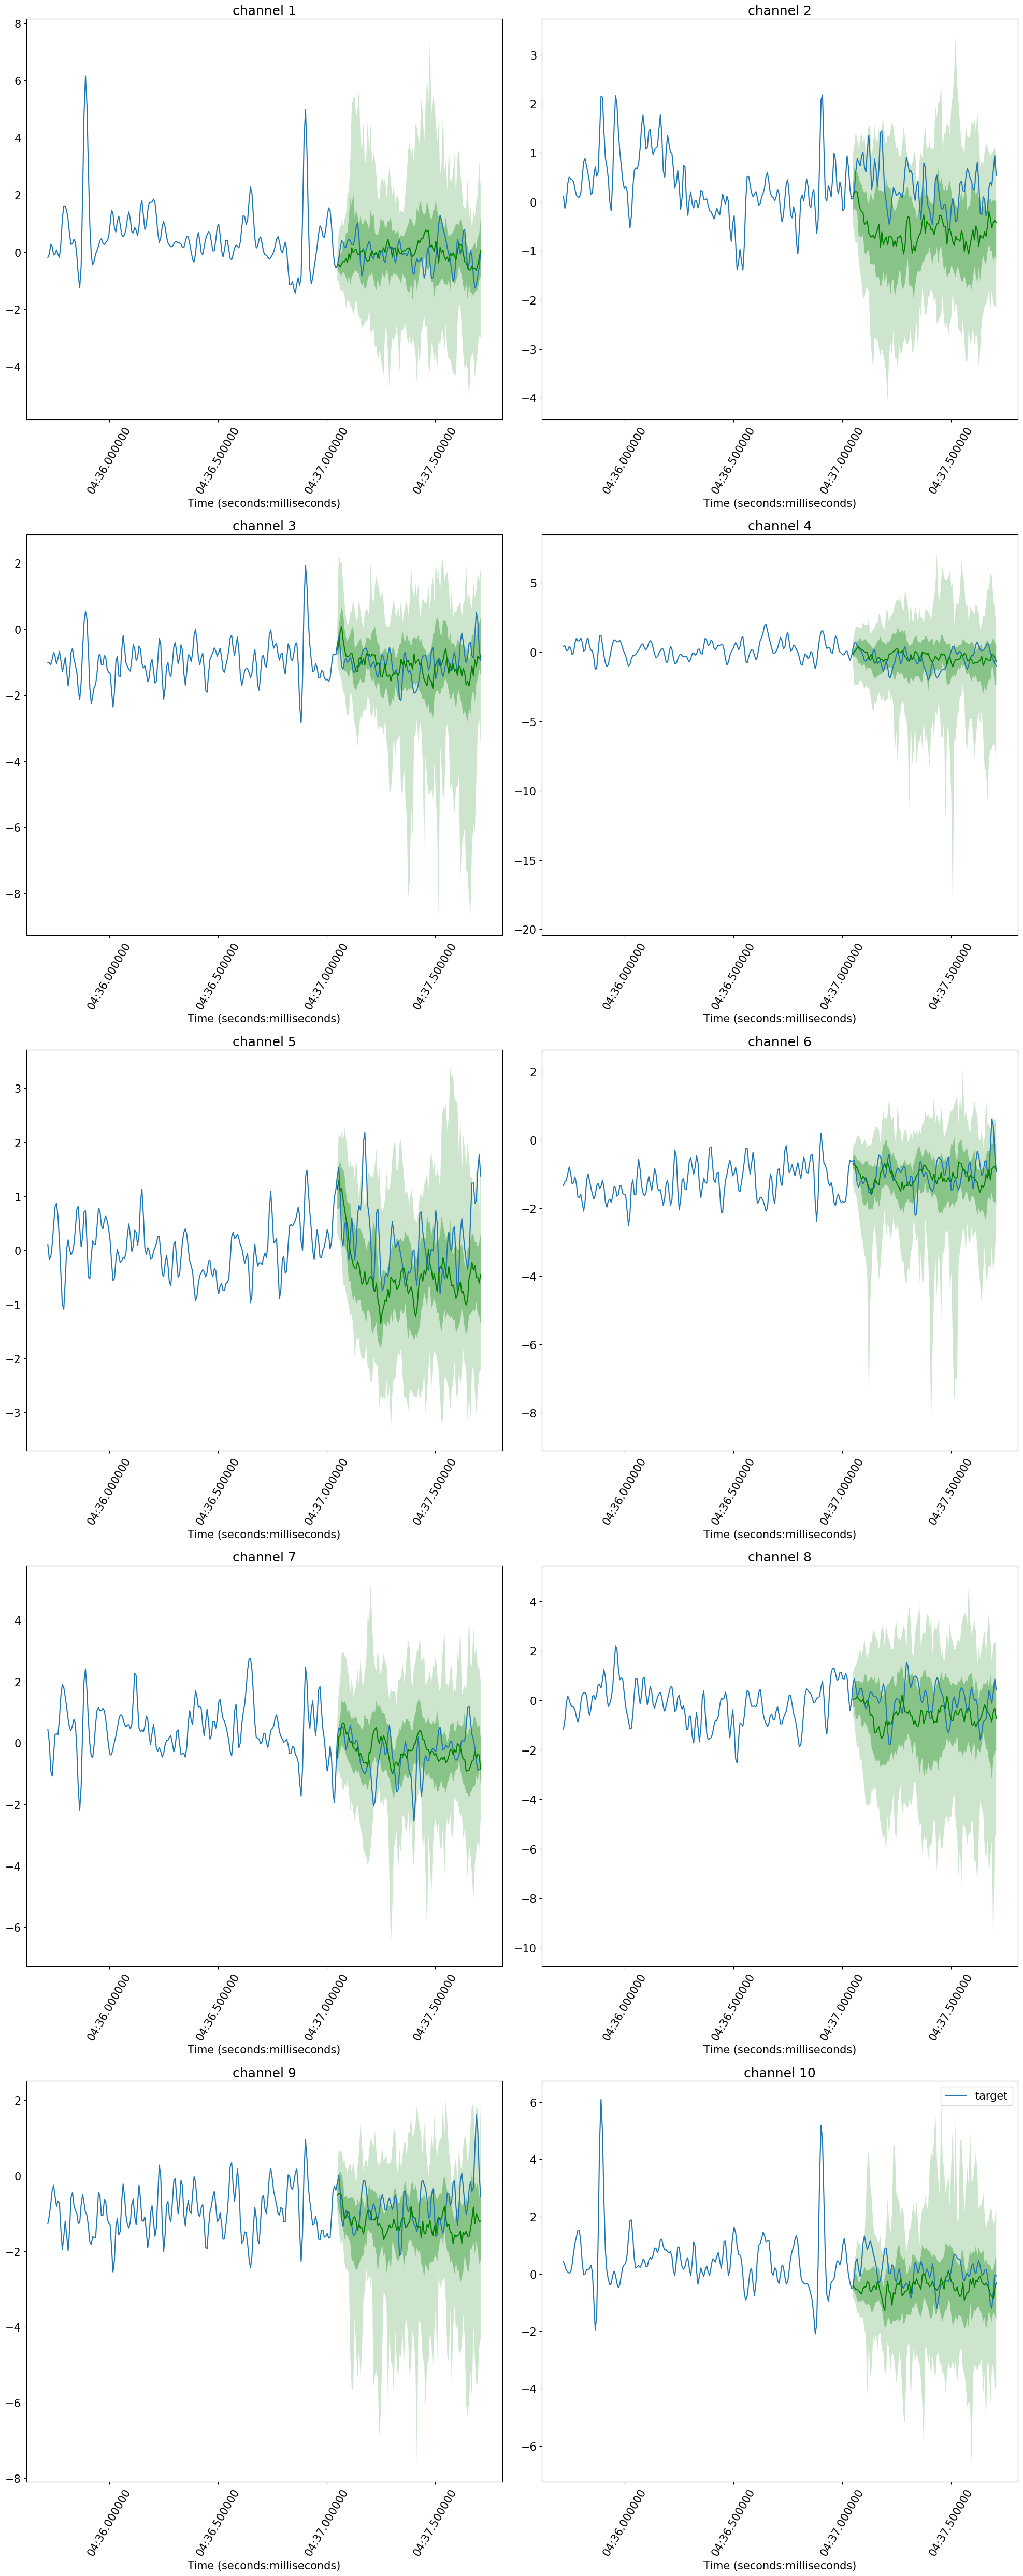

In [115]:
forecasts_arr, tss_arr = [], []
min_max_normalized_data = min_max_normalization(data)

for i in range(NUM_CHANNELS):
  # create dataset for a channel
  dataset = create_dataset(min_max_normalized_data[i])
  # get forecasts and tss for a channel
  forecasts, tss = get_lag_llama_predictions(dataset, PREDICTION_LENGTH, NUM_SAMPLES)
  forecasts_arr.append(forecasts)
  tss_arr.append(tss)

plot(forecasts_arr, tss_arr)

In [104]:
forecast = forecasts_arr[0]
tss = tss_arr[0]
len(forecast[0].samples), len(forecasts[0].samples[0])

(40, 100)

In [19]:
type(tss[0]), tss[0]

(pandas.core.frame.DataFrame,
                                           0
 2023-01-01 00:00:00.000000000 -1.622447e-12
 2023-01-01 00:00:00.006659840 -3.827357e-12
 2023-01-01 00:00:00.013319680 -7.420960e-12
 2023-01-01 00:00:00.019979520 -1.122285e-11
 2023-01-01 00:00:00.026639360 -1.322736e-11
 ...                                     ...
 2023-01-01 00:04:37.682028800 -1.800060e-11
 2023-01-01 00:04:37.688688640 -1.732380e-11
 2023-01-01 00:04:37.695348480 -1.540656e-11
 2023-01-01 00:04:37.702008320 -1.317047e-11
 2023-01-01 00:04:37.708668160 -9.936557e-12
 
 [41700 rows x 1 columns])

In [20]:
tss[0].iloc[-24:]

,0
2023-01-01 00:04:37.555491840,-8.869475e-12
2023-01-01 00:04:37.562151680,-1.022631e-11
2023-01-01 00:04:37.568811520,-1.147326e-11
2023-01-01 00:04:37.575471360,-1.405857e-11
2023-01-01 00:04:37.582131200,-1.659313e-11
2023-01-01 00:04:37.588791040,-1.544767e-11
2023-01-01 00:04:37.595450880,-1.051193e-11
2023-01-01 00:04:37.602110720,-6.785193e-12
2023-01-01 00:04:37.608770560,-7.781800e-12
2023-01-01 00:04:37.615430400,-1.020291e-11


In [21]:
forecast[0].samples[0]

array([-6.4694404e-12, -9.1409345e-13, -5.4679330e-12, -2.5075545e-12,
       -2.8208202e-12, -4.8427525e-12, -4.9492446e-12, -5.1954218e-12,
       -4.4100921e-12, -5.6008262e-12, -5.3892489e-12, -4.9888370e-12,
       -5.9822607e-12, -3.7538826e-12, -3.5344110e-12, -5.2925043e-12,
       -5.4047955e-12, -5.6140674e-12, -4.7912395e-12, -4.0302353e-12,
       -5.8692278e-12, -5.7879825e-12, -4.0814522e-12, -5.5426020e-12,
       -5.4160882e-12, -7.0390295e-12, -4.8889946e-12, -5.0222951e-12,
       -5.0708448e-12, -5.9480684e-12, -3.6944397e-12, -5.1693866e-12,
       -5.5929488e-12, -4.7616191e-12, -5.0770113e-12, -7.1683865e-12,
       -4.1969002e-12, -5.9114601e-12, -5.6009464e-12, -4.8482121e-12,
       -5.5865325e-12, -4.4388061e-12, -5.3983272e-12, -5.2735299e-12,
       -5.3736386e-12, -3.6015340e-12, -4.5451199e-12, -5.3396289e-12,
       -7.2470745e-12, -5.4165825e-12, -5.1850490e-12, -4.4680089e-12,
       -5.3664347e-12, -5.1923093e-12, -5.8453424e-12, -5.7294104e-12,
      

In [62]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

Running evaluation: 1it [00:00, 16.37it/s]


CRPS: 1.1899669362353067
